In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [40]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last date of entry
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the date 365 days from the last date.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Retrieve the last 12 months of precipitation data
one_yr_prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()

# Load the results into a pandas dataframe.

precipitation_df = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Reset the index to the 'Date'
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()

,Date,Prcp
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22


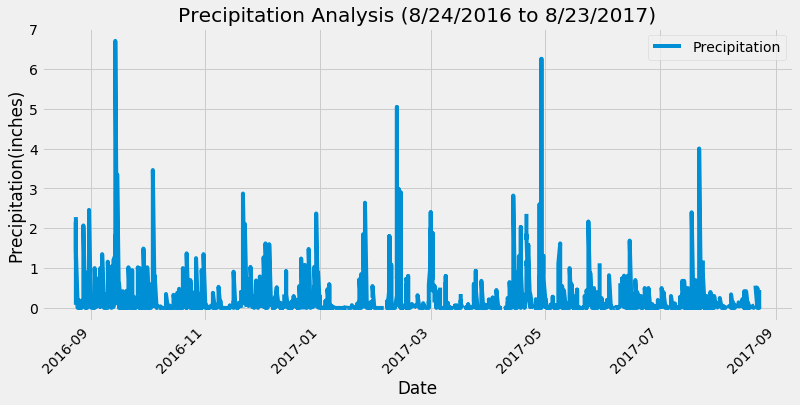

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print("There are {} stations.".format(station_count))

There are 9 stations.


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_tobs = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

#List the stations and the counts in descending order.

print("The stations with the highest number of observations in descending order are:")
print()
for station, count in station_tobs:
    print("Station:",station, "has",count, "observations.")
    

The stations with the highest number of observations in descending order are:

Station: USC00519281 has 2772 observations.
Station: USC00519397 has 2724 observations.
Station: USC00513117 has 2709 observations.
Station: USC00519523 has 2669 observations.
Station: USC00516128 has 2612 observations.
Station: USC00514830 has 2202 observations.
Station: USC00511918 has 1979 observations.
Station: USC00517948 has 1372 observations.
Station: USC00518838 has 511 observations.


In [57]:
station_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [73]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

top_station_stats = station_tobs[0][0]

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == top_station_stats).all()


[(54.0, 71.66378066378067, 85.0)]

In [80]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == top_station_stats).\
                filter(Measurement.date >= first_date).all()
temp_obs_df = pd.DataFrame(temp_results)
temp_obs_df.set_index('station', inplace=True)
temp_obs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

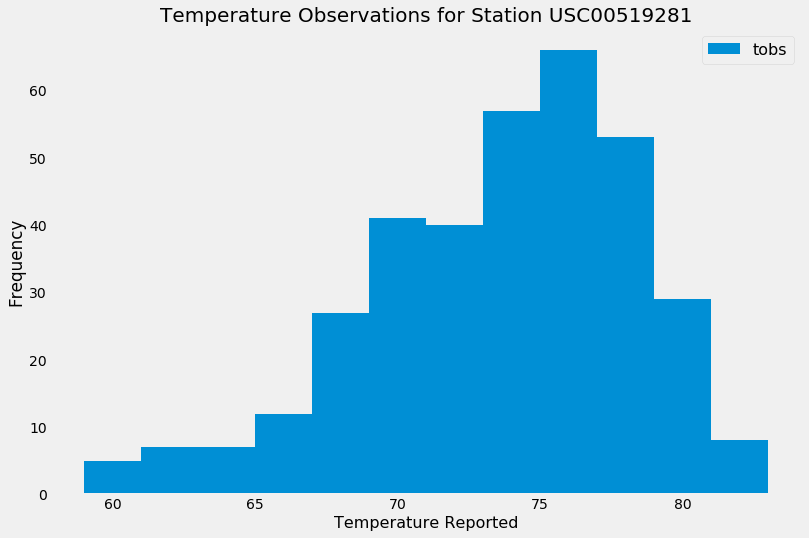

In [82]:
# Plot the results as a histogram with bins=12

temp_obs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + top_station_stats, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("StationTemps.png")
plt.show

In [83]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [84]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_results = calc_temps('2017-07-02', '2017-07-08')
trip_results

[(71.0, 78.11904761904762, 87.0)]

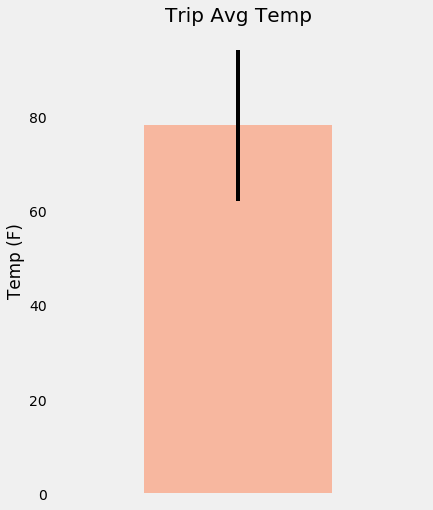

In [86]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



,Min Temp,Avg Temp,Max Temp
0,71.0,78.119048,87.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


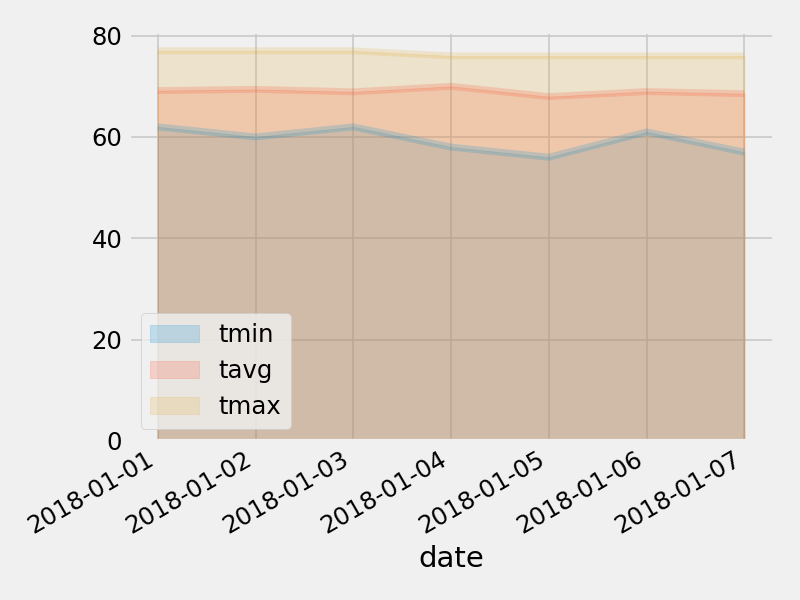

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
